# Sentiment Analysis of Yelp Reviews - Data Wrangling

#### Prepared By: Ben Chamblee

## Contents

* [Introduction](#Introduction)  
* [Scraping HTML from Yelp URL](#Scraping_HTML_from_Yelp_URL)
* [Yelp API](#Yelp_API)
* [Getting the Data](#Getting_the_Data)
* [Proving Zipf's Law](#Zipf)
* [Stemming and Lemmatization](#Stem_and_Lem)

## Introduction

The goal for this project is to use a combination of Natural Language Processing and web scraping to interpret and collect review data from locations on Yelp. Once we have this data we can analyze it and determine the sentiment of any location based on the text of their reviews.

This notebook is centered around the collecting asepct of the project. We'll be using a variety of unique libraries and techniuqes to get data from Yelp.

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Objectives

- Successfully collect data from one location on Yelp
- Determine a method of applying this data collection to a larger scale
- Transform the data so that it's usable in future notebooks, as a csv or excel file
- Make sure the data is cleaned and ready to use

## Scraping HTML from Yelp URL<a id='Scraping_HTML_from_Yelp_URL'></a>

In [9]:
# test with one url, a starbucks in new york

url1 = 'https://www.yelp.com/biz/starbucks-new-york'

url = 'https://www.yelp.com/biz/starbucks-new-york-415'

In [3]:
# we need a proxy so that our IP doesn't get banned from yelp 

from lxml.html import fromstring
import urllib.request
import requests

def get_proxies():
    url = 'https://free-proxy-list.net/'
    response = requests.get(url)
    parser = fromstring(response.text)
    proxies = set()
    for i in parser.xpath('//tbody/tr')[:10]:
        if i.xpath('.//td[7][contains(text(),"yes")]'):
        #Grabbing IP and corresponding PORT
            proxy = ":".join([i.xpath('.//td[1]/text()')[0], i.xpath('.//td[2]/text()')[0]])
            proxies.add(proxy)
    return proxies

In [4]:
proxies = get_proxies()
proxies

{'158.51.109.34:26019',
 '159.89.221.73:3128',
 '160.16.206.132:3128',
 '161.202.226.194:80',
 '163.172.221.209:443',
 '165.22.64.68:40402',
 '182.72.150.242:8080',
 '81.252.192.166:80'}

In [5]:
# first we need to load the url, then scrape the html using BeautifulSoup
import urllib.request
from bs4 import BeautifulSoup

url = 'https://www.yelp.com/biz/starbucks-new-york'

from bs4 import BeautifulSoup, SoupStrainer

proxy = urllib.request.ProxyHandler({'https': proxies})
opener = urllib.request.build_opener()
website = opener.open(url)

html = website.read()
soup = BeautifulSoup(html, "html.parser")

In [7]:
# after inspecting the webpage html, we know exactly which elements contain the review text

review=[]
for i in soup.find_all('div',{'class':"margin-b2__373c0__abANL border-color--default__373c0__2oFDT"}):
    per_review = i.find_all('span',{'class':"raw__373c0__3rcx7"})
    review.append(per_review)

In [8]:
review

[[],
 [],
 [],
 [<span class="raw__373c0__3rcx7" lang="en">Small location with limited seating, but 80's new wave playing and friendly baristas. <br/><br/>I dropped in for an iced coffee after my workout at the NYSC next door. <br/><br/>Not much else to say. Pretty standard 'bucks menu. Got my drink quickly. Not much seating in this one. Large communal table smack in the middle, and some window seating all crowded up with wifi hogs at every seat.<br/><br/>Basically a grab and go location to me. All good and A-OK.</span>],
 [<span class="raw__373c0__3rcx7" lang="en">The larger Starbucks on 93rd &amp; B'way closed permanently and this one was completely renovated to take out all the seating. So if I want a place to chill with a cup of coffee I will now have to go to the Dunkin with the loud music and crap ambiance. <br/><br/>Crosstown there's a plethora of quaint, cozy non-chain coffee shops with infinitely better coffee. There's a Starbucks on Madison with fantastic banquet seating. I h

In [9]:
# this is pretty messy, let's apply a filter and remove some html tags to clean it up

new_review = list(filter(None, review))

reviews_clean = []
for i in new_review:
    new_i = str(i).replace('<span class="raw__373c0__3rcx7" lang="en">','')
    new_i = new_i.replace('</span>','')
    new_i = new_i.replace('<br/>','')
    new_i = new_i.replace('<br>','')
    new_i = new_i.replace('[','')
    new_i = new_i.replace(']','')
    new_i = new_i.replace('\xa0','')
    new_i = new_i.replace('\'','')
    
    reviews_clean.append(new_i)

In [10]:
reviews_clean

['Small location with limited seating, but 80s new wave playing and friendly baristas. I dropped in for an iced coffee after my workout at the NYSC next door. Not much else to say. Pretty standard bucks menu. Got my drink quickly. Not much seating in this one. Large communal table smack in the middle, and some window seating all crowded up with wifi hogs at every seat.Basically a grab and go location to me. All good and A-OK.',
 'The larger Starbucks on 93rd &amp; Bway closed permanently and this one was completely renovated to take out all the seating. So if I want a place to chill with a cup of coffee I will now have to go to the Dunkin with the loud music and crap ambiance. Crosstown theres a plethora of quaint, cozy non-chain coffee shops with infinitely better coffee. Theres a Starbucks on Madison with fantastic banquet seating. I have yet to find a similar quality place within walking distance from me, and now even the mediocre spots are gone. Every day Im more and more disappoin

Looks good! Now let's see if we can use this method to collect data on, 1000 locations in NYC? First we'll need to find the 1000 restaurant names in NYC, for that we turn to NYC Open Data!

In [11]:
import requests
import json

nyc_list = 'https://data.cityofnewyork.us/resource/59dk-tdhz.json'
session = requests.Session()
session.mount('http://', requests.adapters.HTTPAdapter(max_retries=3))
raw_data = session.get(nyc_list)
nyc_data = raw_data.json()

restaurant_names= []

for i in range(1000):
    name = nyc_data[i]['dba']
    restaurant_names.append(name)

# test
restaurant_names[2]

'DJ REYNOLDS PUB AND RESTAURANT'

## Yelp API<a id='Yelp_API'></a>

In order to convert business names to valid Yelp urls that we can scrape, we need to use Yelp's API which can be found at: 
https://www.yelp.com/fusion

In [12]:
# HIDE THIS BEFORE YOU PUBLISH

    api_key='HV6uMLD80NH9yV9B-c7QC_SrfnL7vqmM-CF_dT5QBIB4EPjWnGfyJ3vd69fYAQbOR2wq0qcpulbeiIl3Fwa2yr2ckJWPszdhw6JEIDXxs9uTQ0Z_BNEBk0SfMp-uYHYx'
    headers = {'Authorization': 'Bearer %s' % api_key}

# this is the url that yelp with search to find a valid business url
search_url='https://api.yelp.com/v3/businesses/search'
 
# in the dictionary, term can take values like food, cafes or businesses
# lets test with the location we just found from the NYC database
params = {'term':restaurant_names[2],'location':'New York City'}

In [13]:
req=requests.get(search_url, params=params, headers=headers)
 
# proceed only if the status code is 200
print('The status code is {}'.format(req.status_code))

The status code is 200


In [14]:
restaurant_2 = json.loads(req.text)

type(restaurant_2['businesses'])

list

Now we can add the alias, in this case 'd-j-reynolds-new-york-5' to the end of our parent url 'https://www.yelp.com/biz/' to get a valid url for this location

from here the process is just like before, use the url to scrape the html then find all the reviews and clean it up like above, lets write a function that does this for all 1000 locations

the only other step we need to add is to load more pages so we can get more than 10 reviews per location

## Getting the Data<a id='Getting_the_Data'></a>

In [15]:
import time
import random
import pyautogui


def yelp_web_scraper(locations):
    
    # This function creates a dataframe and several lists to add to the dataframe, the output will be the dataframe
    
    yelp_data = pd.DataFrame()
    alias_list = []
    name_list = []
    rating_list = []
    price_list = []
    city_list = []
    zip_code_list = []
    address_list = []
    review_list = []
    total_reviews = []
    
    #convert business names to urls  
    for location in locations:
        sec = random.randint(10,15)
        time.sleep(sec)
        alias = ''
        name = ''
        rating = ''
        price = ''
        city = ''
        zip_code = ''
        address = ''
        all_urls = []
        all_reviews = []
        
        params = {'term':location,'location':'New York City'}

        req=requests.get(search_url,params=params, headers=headers)
        
        if req.status_code != 200:
            continue
        
        rest_data = json.loads(req.text)
        
        # not every location has these same parameters, so we need to check them all so we don't run into errors
        
        if 'businesses' in rest_data:
        
            if isinstance(rest_data['businesses'], list):
        
                if 'alias' in rest_data['businesses'][0]:
                    alias = rest_data['businesses'][0]['alias']
        
                if 'name' in rest_data['businesses'][0]:
                    name = rest_data['businesses'][0]['name']
            
                if 'rating' in rest_data['businesses'][0]:
                    rating = rest_data['businesses'][0]['rating']
            
                if 'price' in rest_data['businesses'][0]:
                    price = rest_data['businesses'][0]['price']
        
                if 'location' in rest_data['businesses'][0]:
                    if 'city' in rest_data['businesses'][0]['location']:
                        city = rest_data['businesses'][0]['location']['city']
                    if 'zip_code' in rest_data['businesses'][0]['location']:
                        zip_code = rest_data['businesses'][0]['location']['zip_code']
                    if 'display_address' in rest_data['businesses'][0]['location']:
                        address = rest_data['businesses'][0]['location']['display_address'][0]
        
        alias_list.append(alias)
        name_list.append(name)
        rating_list.append(rating)
        price_list.append(price)
        city_list.append(city)
        zip_code_list.append(zip_code)
        address_list.append(address)
        
        add_url = alias
        parent_url = parent_url = 'https://www.yelp.com/biz/'
        
        url = parent_url + add_url
        
    #add more urls to get more reviews
    
            
        #luckily we can just add one of these tags to the end of a url to load the next page of reviews
        #most places seemed to have no more than 7 pages, so I decided to go with that as my max
    
        pages =['?start=10','?start=20','?start=30','?start=40','?start=50','?start=60']
        page1 = url
        page2 = url+pages[0]
        page3 = url+pages[1]
        page4 = url+pages[2]
        page5 = url+pages[3]
        page6 = url+pages[4]
        page7 = url+pages[5]
    
        all_urls.append([page1,page2,page3,page4,page5,page6,page7])
    
    #scrape all urls
    #in order to not be labeled as a robot, we need to appear more human by waitng a random amount of time
    #and move our mouse around
    
        for index in range(len(all_urls[0])):
            sec2 = random.randint(5,10)
            mouse_sec = random.randint(1,2)
            mouse_coords = random.randint(100,800)
            time.sleep(sec2)
            pyautogui.moveTo(mouse_coords*2, mouse_coords, duration = mouse_sec)
            
            url = all_urls[0][index]
            url = url.encode('ascii', 'ignore').decode('ascii')
            response = requests.get(url)
            if response.status_code != 200: #could also check == requests.codes.ok
                continue
            re_text = response.text
            soup = BeautifulSoup(re_text,'html.parser')
            
            review=[]
            for i in soup.find_all('div',{'class':"margin-b2__373c0__abANL border-color--default__373c0__2oFDT"}):
                per_review = i.find_all('span',{'class':"raw__373c0__3rcx7"})
                review.append(per_review)
            new_review = list(filter(None, review))
        
            reviews_clean = []
            for x in new_review:
                new_i = str(x).replace('<span class="raw__373c0__3rcx7" lang="en">','')
                new_i = new_i.replace('<span class="raw__373c0__3rcx7">','')
                new_i = new_i.replace('</span>','')
                new_i = new_i.replace('<br/>','')
                new_i = new_i.replace('<br>','')
                new_i = new_i.replace('[','')
                new_i = new_i.replace(']','')
                new_i = new_i.replace('\xa0','')
                new_i = new_i.replace('\'','')
    
                reviews_clean.append(new_i)
            for review in reviews_clean:
                all_reviews.append(review)
        
        review_list.append(all_reviews)
        total_reviews.append(len(all_reviews))
    #add to a dataframe  
        
        
        
    yelp_data['alias'] = alias_list
    yelp_data['name'] = name_list
    yelp_data['rating'] = rating_list
    yelp_data['price'] = price_list
    yelp_data['city'] = city_list
    yelp_data['zip_code'] = zip_code_list
    yelp_data['address'] = address_list
    yelp_data['reviews'] = review_list
    yelp_data['total_reviews'] = total_reviews
 
    return yelp_data

To make sure our function works we're going to test it with the same location as above

In [77]:
test_list = []
test_list.append(restaurant_names[1])

In [82]:
testData = yelp_web_scraper(test_list)

In [83]:
testData

,alias,name,rating,price,city,zip_code,address,reviews,total_reviews
0,wendys-new-york-11,Wendy's,3.0,$,New York,10038,85 Nassau Street,[I will say that I have never had a problem wi...,70


Looks like it works, we have 70 reviews from this location and we can access each individual review like this:

In [52]:
testData['reviews'][0][15]

'I ordered a large fries with spicy chicken burger. In the middle of eating, I noticed a stringy vein attached in the chicken! Is it even completely cooked?!?! As you see on the picture, I lightly pull onto it but still stuck inside the meat. I am disgusted and will never order here again!!'

Now we can apply this to our full list to get 10000 reviews

In [113]:
#full_set

restaurants = restaurant_list[0:270]
yelp_data = yelp_web_scraper(restaurants)

In [98]:
yelp_dataset = yelp_dataset.append(yelp_data)

In [97]:
yelp_dataset.head()

,alias,name,rating,price,city,zip_code,address,reviews,total_reviews
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,['The chocolate cups are amazing! Have been ea...,54
1,wendys-new-york-11,Wendy's,3.0,$,New York,10038,85 Nassau Street,['I will say that I have never had a problem w...,70
2,d-j-reynolds-new-york-5,D.J. Reynolds,3.5,$$,New York,10019,351 W 57th St,['Please note that the new hours are: Tuesday-...,60
3,riviera-caterers-brooklyn,Riviera Caterers,4.5,NaN,Brooklyn,11224,2780 Stillwell Ave,['Got a question about Riviera Caterers? Ask t...,58
4,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,3.5,$$,Brooklyn,11234,7114 Ave U,['So inspite of the tiny issues im still leavi...,51


Looks good! Now I'll make a seperate dataframe where each review is on a seperate row

In [68]:
yelp_dataset_unpacked = pd.DataFrame()

In [76]:
full_alias = []
full_name = []
full_rating = []
full_price = []
full_city = []
full_zip = []
full_address = []
full_review = []


for index, location in enumerate(yelp_dataset['alias']):
    
    alias = location
    name = yelp_dataset[yelp_dataset['alias'] == location]['name'].values
    rating = yelp_dataset[yelp_dataset['alias'] == location]['rating'].values
    price = yelp_dataset[yelp_dataset['alias'] == location]['price'].values
    city = yelp_dataset[yelp_dataset['alias'] == location]['city'].values
    zip_code = yelp_dataset[yelp_dataset['alias'] == location]['zip_code'].values
    address = yelp_dataset[yelp_dataset['alias'] == location]['address'].values
    reviews = yelp_dataset[yelp_dataset['alias'] == location]['reviews'][index]
    reviews = list(reviews.split("\', "))
    
    for review in reviews:
        
        full_alias.append(alias)
        full_name.append(name[0])
        full_rating.append(rating[0])
        full_price.append(price[0])
        full_city.append(city[0])
        full_zip.append(zip_code[0])
        full_address.append(address[0])
        full_review.append(review)
        
yelp_dataset_unpacked['Alias'] = full_alias
yelp_dataset_unpacked['Name'] = full_name
yelp_dataset_unpacked['Rating'] = full_rating
yelp_dataset_unpacked['Price'] = full_price
yelp_dataset_unpacked['City'] = full_city
yelp_dataset_unpacked['Zip_code'] = full_zip
yelp_dataset_unpacked['Address'] = full_address
yelp_dataset_unpacked['Review'] = full_review
        

The only thing left is to clean up the first and last reviews, this conversion left behind a few brackets so I'll filter those out now

In [87]:
for index, reviews in enumerate(yelp_dataset_unpacked['Review']):
    new_i = str(reviews).replace('[','')
    yelp_dataset_unpacked['Review'][index] = new_i

C:\Users\Benja\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [91]:
for index, reviews in enumerate(yelp_dataset_unpacked['Review']):
    new_i = str(reviews).replace(']','')
    yelp_dataset_unpacked['Review'][index] = new_i

C:\Users\Benja\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [96]:
yelp_dataset_unpacked.to_csv(r'yelp_data.csv',index=False)

In [99]:
yelp_dataset_unpacked.head()

,Alias,Name,Rating,Price,City,Zip_code,Address,Review
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'The chocolate cups are amazing! Have been eat...
1,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'Morris Park Bake Shop has become my go to spo...
2,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'I thought the cookies and biscotti were prett...
3,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'Guys.... so Im a big time biscotti connoisseu...
4,morris-park-bake-shop-bronx,Morris Park Bake Shop,4.5,$$,Bronx,10462,1007 Morris Park Ave,'I had a craving for a special type of cake wi...


Now that we have all this data we can analyze it and start to determine the sentiment, but first I'd like to try something

## Proving Zipf's Law<a id='Zipf'></a>

If you're not familiar with Zipf's Law, it basically states that for a large sample of words, the frequency of any word follows an inversely proportional pattern to it's rank. The most common word, usually 'the' will appear twice as much as the second most common word and vice versa. Here's a visual representation:

<img src="zipfs.jpg" alt="Drawing" align = "left" style="width: 450px;"/>

With over 10,000 reviews, we should be able to prove Zipf's law!

First we need to find the counts of each word in a review

In [114]:
from collections import Counter
import re

rev1 = yelp_dataset_unpacked['Review'][4]

words = re.findall(r'\w+', rev1.lower())
Counter(words).most_common(10)

[('and', 4),
 ('a', 3),
 ('cake', 3),
 ('it', 3),
 ('had', 2),
 ('for', 2),
 ('layer', 2),
 ('this', 2),
 ('the', 2),
 ('bakery', 2)]

Then we can get a list of every word from every review

In [123]:
all_words = []

for review in yelp_dataset_unpacked['Review']:
    words = re.findall(r'\w+', review.lower())
    for word in words:
        all_words.append(word)

In [178]:
# the picture above has 20 bars, so lets go with that for our chart as well
zipf = Counter(all_words).most_common(20)

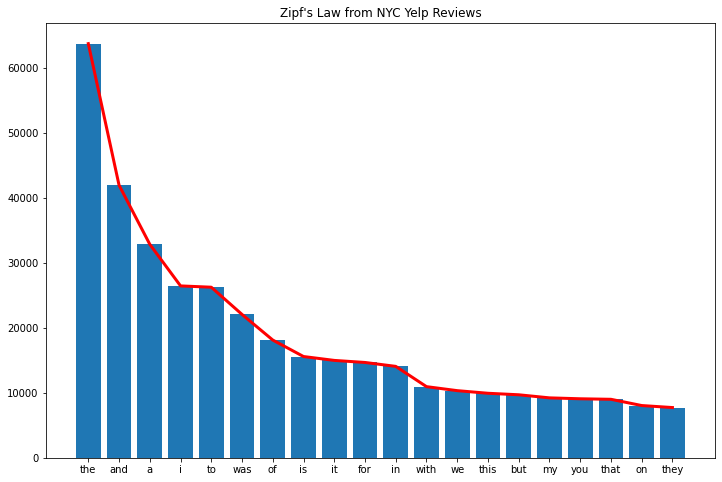

In [180]:
x = pd.DataFrame(zipf, columns=['word','count']).set_index('word')
plt.figure(figsize=(12,8)) 
plt.bar(x.index, x['count'])
plt.plot(x['count'],color='red',linewidth=3)
plt.title("Zipf's Law from NYC Yelp Reviews");

I think this is really interesting, especially because this chart and the example above both start with 'the' and end with 'they'

## Conclusion

Now that we've got our data, we need to trim it down into a more usable format. The next step in Exploratory analysis is to use tokenization and stemming to get a better idea of what the actual meaning behind each review is. Once you remove common, or stop words like 'the' 'and' 'to' and all those, you can really get an idea of what each review is saying. We'll handle that part next!